# Imports

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.signal as scs
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.api import VAR, VARMAX
import requests
import json


time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),et0_fao_evapotranspiration (mm)

In [11]:
df = pd.read_csv("../data/open_meteo_tokyo_multivariative.csv")
df.head()

time  weather_code  temperature_max  temperature_min  \
0  1940-01-02             3              3.5             -1.9   
1  1940-01-03             1              9.3             -0.8   
2  1940-01-04             1              9.6              1.3   
3  1940-01-05             1             14.5             -0.4   
4  1940-01-06            51             10.4              0.4   

   temperature_mean  apparent_temperature_max  apparent_temperature_min  \
0               0.5                      -0.1                      -4.9   
1               3.1                       5.9                      -4.8   
2               5.0                       5.4                      -1.9   
3               5.8                      10.5                      -3.9   
4               4.3                       8.2                      -2.3   

   apparent_temperature_mean           sunrise            sunset  ...  \
0                       -3.0  1940-01-01T21:50  1940-01-02T07:38  ...   
1                       -0.4  1940-01-02T21:51  1940-01-03T07:39  ...   
2                        1.3  1940-01-03T21:51  1940-01-04T07:40  ...   
3                        2.3  1940-01-04T21:51  1940-01-05T07:41  ...   
4                        1.6  1940-01-05T21:51  1940-01-06T07:42  ...   

   sunshine_duration  precipitation_sum  rain_sum  snowfall_sum  \
0           23319.52                0.0       0.0           0.0   
1           31386.91                0.0       0.0           0.0   
2           31522.01                0.0       0.0           0.0   
3           31531.86                0.0       0.0           0.0   
4           30139.26                0.1       0.1           0.0   

   precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  \
0                  0.0                10.0                16.2   
1                  0.0                17.0                26.6   
2                  0.0                17.5                31.3   
3                  0.0                26.6                46.1   
4                  1.0                15.2                28.4   

   wind_direction_10m_dominant  shortwave_radiation_sum  \
0                           21                     5.05   
1                          196                    10.72   
2                          218                    11.43   
3                          240                    11.42   
4                           12                     8.05   

   et0_fao_evapotranspiration  
0                        0.65  
1                        1.28  
2                        1.58  
3                        1.65  
4                        0.96  

[5 rows x 21 columns]

In [52]:
df.isna().sum()

time                           0
weather_code                   0
temperature_max                0
temperature_min                0
temperature_mean               0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
sunrise                        0
sunset                         0
daylight_duration              0
sunshine_duration              0
precipitation_sum              0
rain_sum                       0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
dtype: int64

In [12]:
x = np.arange(df.shape[0])
y = np.array(df['temperature_mean'])

coefficients = np.polyfit(x, y, 1)
p = np.poly1d(coefficients)

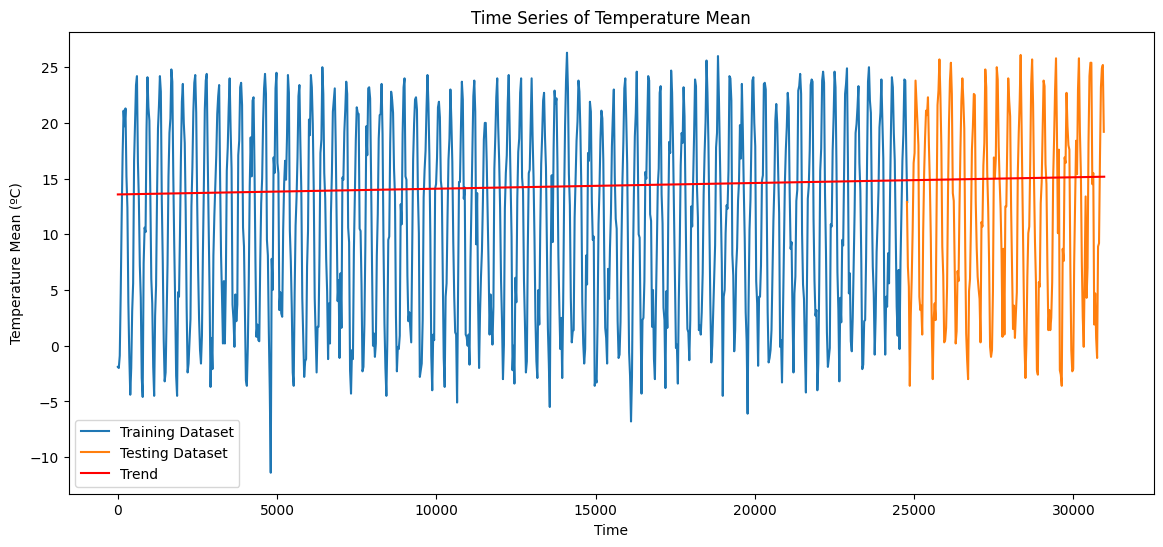

In [4]:
plt.figure(figsize=(14, 6))

plt.plot(df['temperature_min'][:int(df.shape[0] * 0.8)+30:30])
plt.plot(df['temperature_min'][int(df.shape[0] * 0.8)::30])
plt.plot(x, p(x), label='Linear Fit', color='red')

plt.title("Time Series of Temperature Mean")
plt.xlabel("Time")
plt.ylabel("Temperature Mean (ºC)")
plt.legend(["Training Dataset", "Testing Dataset", "Trend"])
plt.show()

TS decomposition models

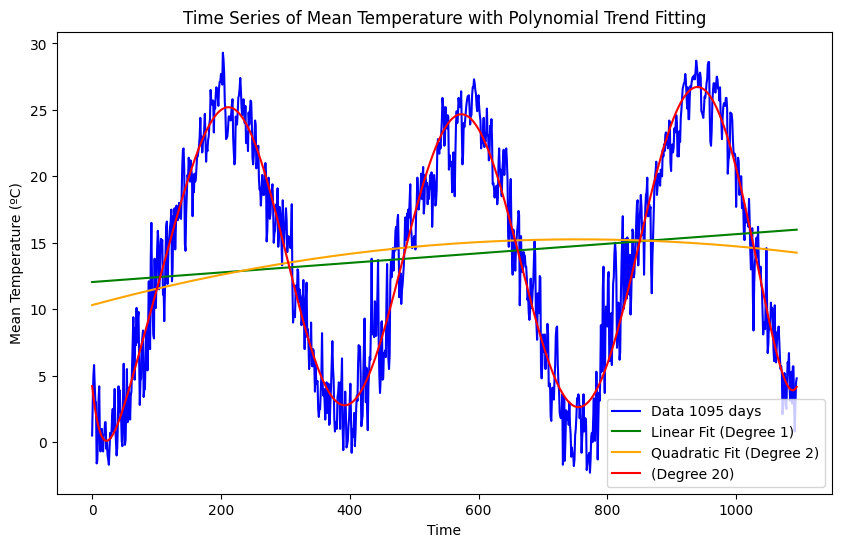

In [55]:
N = 365*3  #3 years
df2 = df[:N]
y = np.array(df2['temperature_mean'])
x = np.arange(len(y))

# Fit a linear polynomial (degree 1)
linear_coefficients = np.polyfit(x, y, 1)
linear_trend = np.poly1d(linear_coefficients)


# Fit a quadratic polynomial (degree 2)
quadratic_coefficients = np.polyfit(x, y, 2)
quadratic_trend = np.poly1d(quadratic_coefficients)


# Fit a polynomial with other degree
n_coefficients = np.polyfit(x, y, 12)
n_trend = np.poly1d(n_coefficients)

# Plotting the original data and polynomial trends
plt.figure(figsize=(10, 6))


plt.plot(df2['temperature_mean'][:df2.shape[0]:], label="Data " + str(N) + " days", color="blue")


# Plot the polynomial fits
plt.plot(x, linear_trend(x), label='Linear Fit (Degree 1)', color='green')
plt.plot(x, quadratic_trend(x), label='Quadratic Fit (Degree 2)', color='orange')
plt.plot(x, n_trend(x), label='(Degree 20)', color='red')

# Add title, labels, and legend
plt.title("Time Series of Mean Temperature with Polynomial Trend Fitting")
plt.xlabel("Time")
plt.ylabel("Mean Temperature (ºC)")
plt.legend()

# Show the plot
plt.show()

Additive model

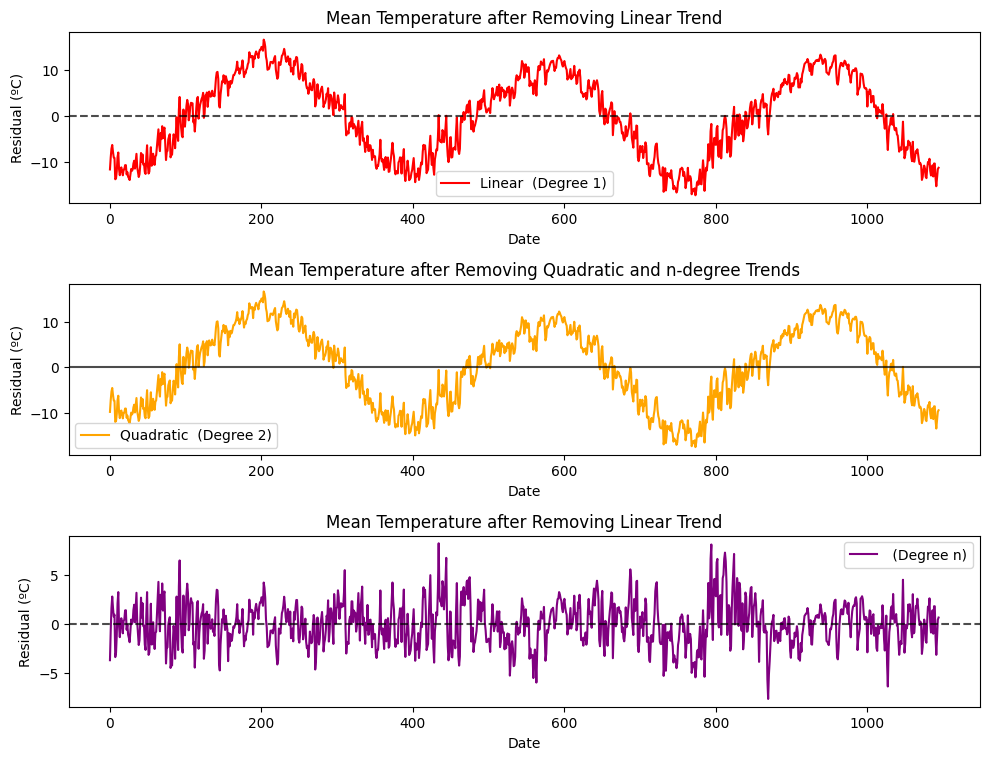

In [56]:
# Subtract the trends from the original time series to get residuals
# additive model
linear_residuals = y - linear_trend(x)
quadratic_residuals = y - quadratic_trend(x)
n_residuals = y - n_trend(x)

# Plotting the original data and residuals
plt.figure(figsize=(10, 10))


# Remove linear trend
plt.subplot(4, 1, 2)
plt.plot(x, linear_residuals, label="Linear  (Degree 1)", color="red")
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f"Mean Temperature after Removing Linear Trend")
plt.xlabel("Date")
plt.ylabel("Residual (ºC)")
plt.legend()

# Remove quadraic trend 
plt.subplot(4, 1, 3)
plt.plot(x, quadratic_residuals, label="Quadratic  (Degree 2)", color="orange", )
plt.axhline(0, color='black', alpha=0.7)
plt.title(f"Mean Temperature after Removing Quadratic and n-degree Trends")
plt.xlabel("Date")
plt.ylabel("Residual (ºC)")
plt.legend()

# Remove n degree trend
plt.subplot(4, 1, 4)
plt.plot(x, n_residuals, label=" (Degree n)", color="purple",)
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f"Mean Temperature after Removing Linear Trend")
plt.xlabel("Date")
plt.ylabel("Residual (ºC)")
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Multiplicative Model

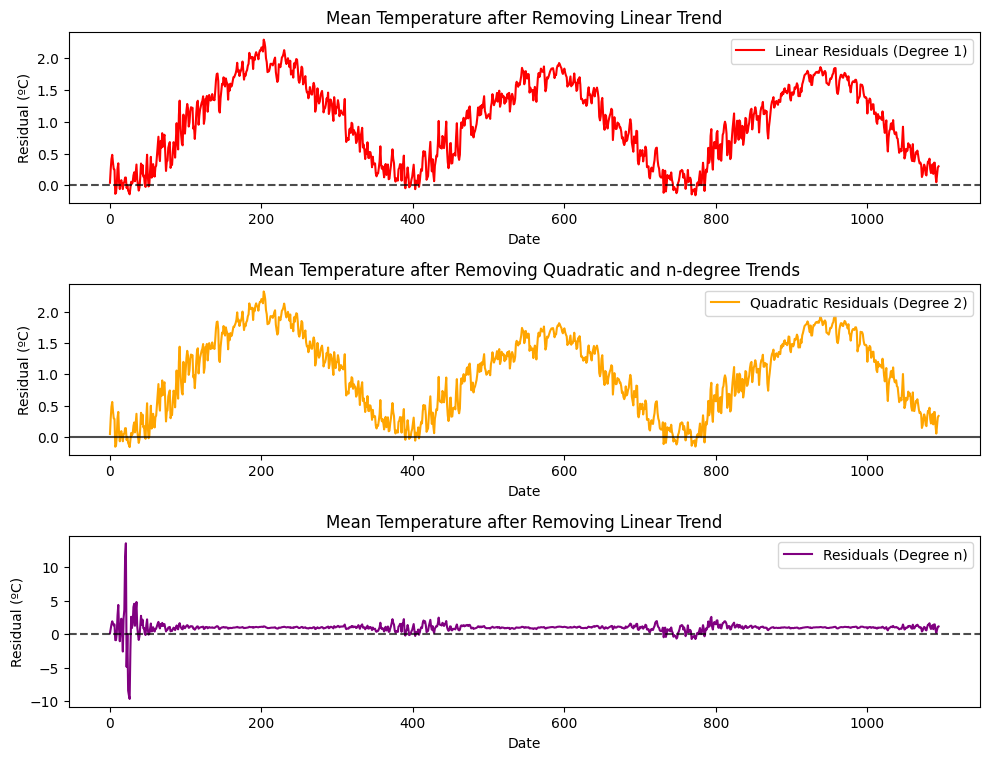

In [57]:
# Divide the trends from the original time series to get residuals
# Multiplicative model
linear_residuals = y / linear_trend(x)
quadratic_residuals = y / quadratic_trend(x)
n_residuals = y / n_trend(x)

# Plotting the original data and residuals
plt.figure(figsize=(10, 10))


# Remove linear trend
plt.subplot(4, 1, 2)
plt.plot(x, linear_residuals, label="Linear Residuals (Degree 1)", color="red")
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f"Mean Temperature after Removing Linear Trend")
plt.xlabel("Date")
plt.ylabel("Residual (ºC)")
plt.legend()

# Remove quadraic trend 
plt.subplot(4, 1, 3)
plt.plot(x, quadratic_residuals, label="Quadratic Residuals (Degree 2)", color="orange", )
plt.axhline(0, color='black', alpha=0.7)
plt.title(f"Mean Temperature after Removing Quadratic and n-degree Trends")
plt.xlabel("Date")
plt.ylabel("Residual (ºC)")
plt.legend()

# Remove n degree trend
plt.subplot(4, 1, 4)
plt.plot(x, n_residuals, label="Residuals (Degree n)", color="purple",)
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f"Mean Temperature after Removing Linear Trend")
plt.xlabel("Date")
plt.ylabel("Residual (ºC)")
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Moving Average smoothing

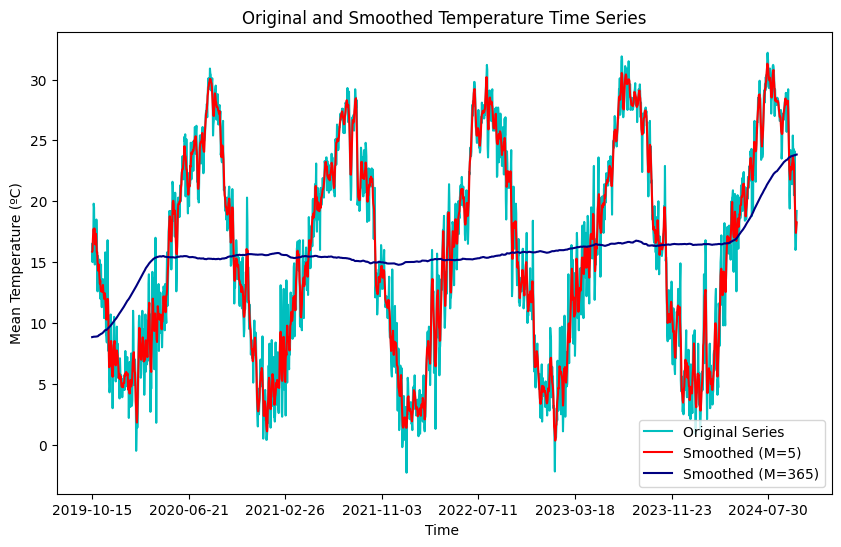

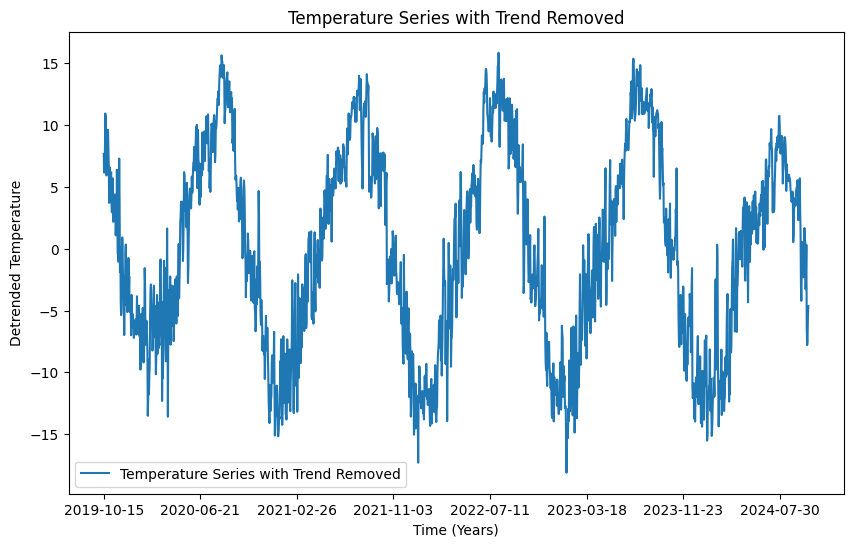

In [58]:
def maSmooth(TSeries,omega,data_aug=False):
    M=omega.shape[0]
    lag=int(np.floor((M-1)/2))
    
    if data_aug: #If smooted TS should have the same number of samples
        #TSeriesAug=TSeries.concat(np.flip(TSeries[-lag:]))
        #TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)
        
        TSeriesAug = pd.concat([TSeries.iloc[lag:0:-1], TSeries, TSeries.iloc[-1:-lag-1:-1]])
    else:
        TSeriesAug=TSeries
        
    nf=range(lag,TSeriesAug.size-lag)
    xf=np.zeros(TSeriesAug.size-2*(lag)).astype('float')
    for n in nf:
        xf[n-lag]=(1/float(sum(omega)))*np.sum(np.multiply(TSeriesAug[n-lag:n+lag+1],omega))
    xf=pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size-lag],name="Smoothed TS with M="+str(M))
    
    return xf


# Convert temperature_mean to a time series
tempTS = pd.Series(data=np.array(df["temperature_mean"]), index=df["time"], name="Mean Temperature TS")

#LAST n days
tempTS = tempTS[-365*5:]

# Apply Moving Average with M=5
M = 5
omega = np.ones(M) * (1 / float(M))  # Uniform weights
smooth5 = maSmooth(tempTS, omega, data_aug=True)

# Apply Moving Average with M=13
M = 365
omega = np.ones(M) * (1 / float(M))
smooth13 = maSmooth(tempTS, omega, data_aug=True)

# Plot the original and smoothed temperature series
plt.figure(figsize=(10, 6))
ax = tempTS.plot(color='c', legend=True, label="Original Series")
smooth5.plot(color='r', legend=True, label="Smoothed (M=5)")
smooth13.plot(color='navy', legend=True, label="Smoothed (M=365)")
ax.set_ylabel('Mean Temperature (ºC)', fontdict={'fontsize':10})
ax.set_xlabel('Time ', fontdict={'fontsize':10})
plt.title("Original and Smoothed Temperature Time Series")
plt.show()

# Remove trend using smoothed series with M=13 (as trend)
tempNoTrend = tempTS - smooth13  
tempNoTrend.name = "Temperature Series with Trend Removed"

# Plot the detrended series
plt.figure(figsize=(10, 6))
ax = tempNoTrend.plot(legend=True)
ax.set_ylabel('Detrended Temperature', fontdict={'fontsize':10})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':10})
plt.title("Temperature Series with Trend Removed")
plt.show()


#TO CREATE A MONTLY SERIES
#df3 = df
#df3['time'] = pd.to_datetime(df3['time'])  # Convert to datetime format
#
## Set the date column as the index (required for resampling)
#df3.set_index('time', inplace=True)
#
## Resample to monthly averages (mean of temperature per month)
#monthly_avg = df3['temperature_mean'].resample('M').mean()



### LOWESS approach

Using sm library

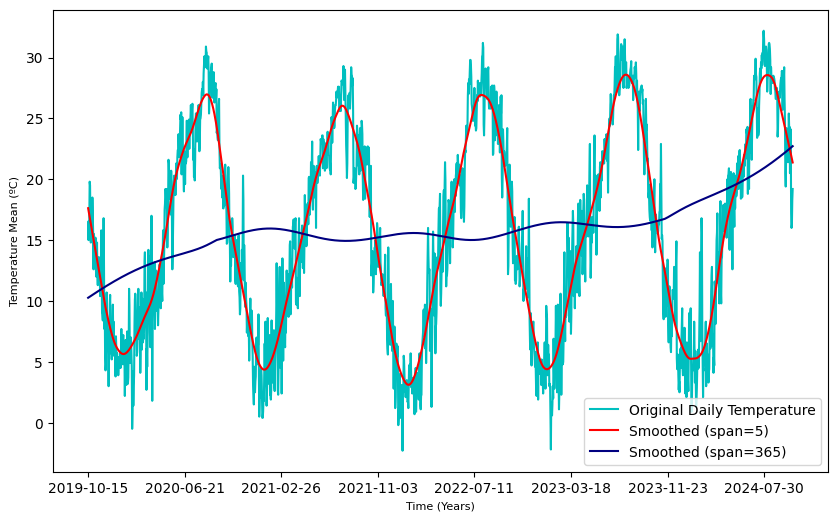

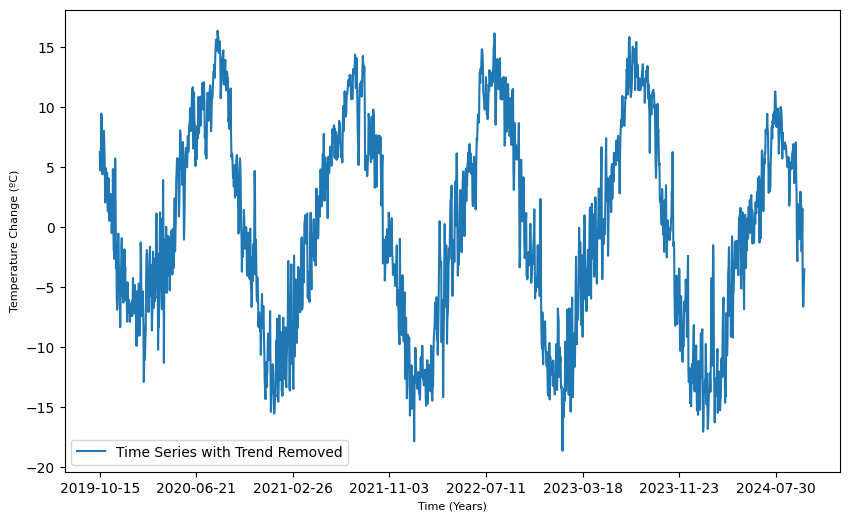

In [59]:
# Apply LOWESS smoothing with different spans (equivalent to M)
span_5 = 0.05  # Adjusted for smoothness, equivalent to M=5
span_365 = 0.365  # Adjusted for smoothness, equivalent to M=13

# Applying LOWESS with different spans
smooth5 = sm.nonparametric.lowess(tempTS, np.arange(len(tempTS)), frac=span_5, return_sorted=False)
smooth365 = sm.nonparametric.lowess(tempTS, np.arange(len(tempTS)), frac=span_365, return_sorted=False)

# Plot the original series and smoothed series
plt.figure(figsize=(10, 6))

# Original data plot
ax = tempTS.plot(color='c', legend=True, label="Original Daily Temperature")

# LOWESS smoothing plot with different spans
plt.plot(tempTS.index, smooth5, color='r', label=f"Smoothed (span=5)")
plt.plot(tempTS.index, smooth365, color='navy', label=f"Smoothed (span=365)")

# Labels and formatting
ax.set_ylabel('Temperature Mean (ºC)', fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':8})
plt.legend()

# Second plot: Removing the trend using smoothed data
plt.figure(figsize=(10, 6))

psNoTrend = tempTS - smooth365
psNoTrend.name = "Time Series with Trend Removed"
ax = psNoTrend.plot(legend=True)
ax.set_ylabel('Temperature Change (ºC)', fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':8})

plt.show()

Teacher's approach

D:\WINDOWS\Local\Temp\ipykernel_27292\4199871489.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xf[k]=res_wls.params[1]*k+res_wls.params[0]


Text(0.5, 0, 'Time (Years)')

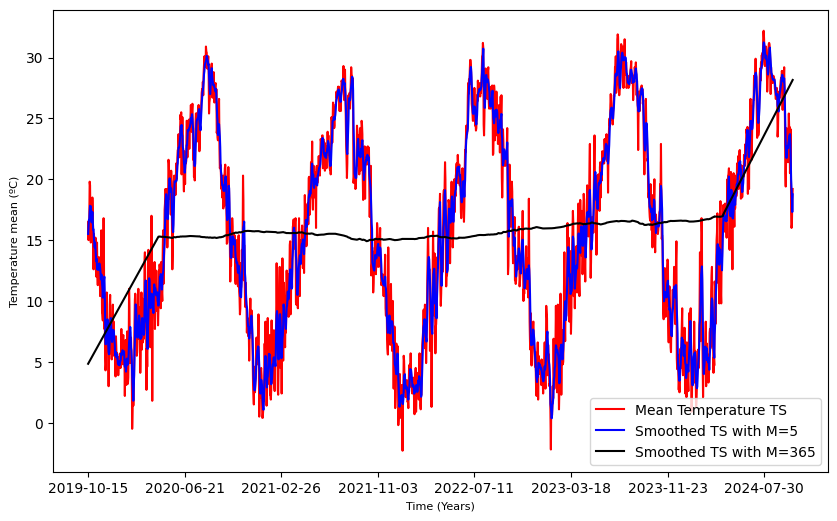

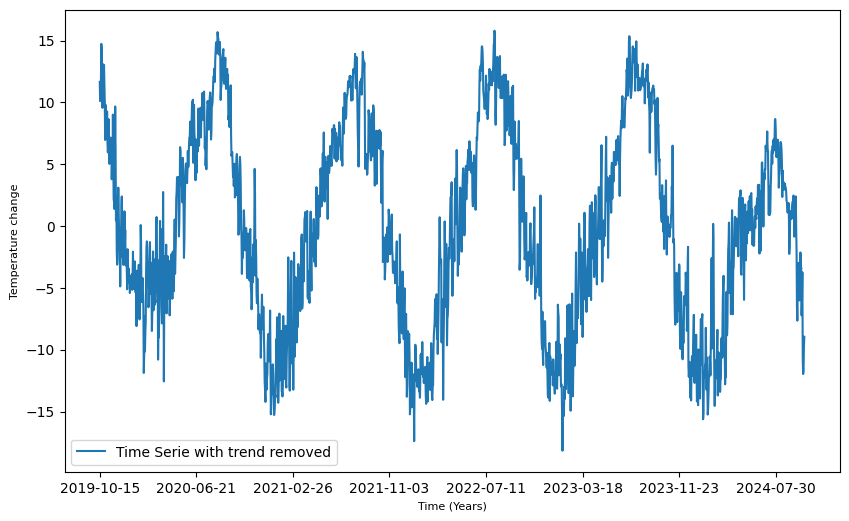

In [60]:
def flin(x,a,b):
    return a*x+b

def xWeights(x,xi,span):
    wi=(1-abs((x-xi)/float(span))**3)**3
    #plt.figure()
    #plt.plot(wi)
    return wi

def yWeights(ri,MAD):
    if np.abs(ri)<6*MAD:
        return (1-((ri/(6*MAD))**2))**2
    else:
        return 0


def loessPass(TSeries,TSeriesE=pd.Series(np.array([])),span=5,timePass=True):
    lag=int((span-1)/2)
    xf=np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k<=lag:
            win=TSeries[0:span]
            if not timePass:
                winE=TSeriesE[0:span]
            xvs=np.array(range(span))
            #print "No inicio"
        elif k>TSeries.size-lag:
            #print "No fim"
            win=TSeries[TSeries.size-span:TSeries.size]
            if not timePass:
                winE=TSeriesE[TSeriesE.size-span:TSeriesE.size]
            xvs=np.array(range(TSeries.size-span,TSeries.size))
        else:
            #print "No meio"
            win=TSeries[k-lag-1:k+lag]
            if not timePass:
                winE=TSeriesE[k-lag-1:k+lag]
            xvs=np.array(range(k-lag,k+lag+1))

        ws=np.zeros(span).astype('float')
            
        if not timePass:
            res=np.array(win-winE)
            #res=res.as_matrix()
            MAD=np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(k,xvs[xw],np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1]))))
            else:
                ws[xw]=yWeights(res[xw],MAD)
            #print np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1])))
        exog = sm.add_constant(xvs)
        
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k]=res_wls.params[1]*k+res_wls.params[0]
    return xf

def lowess(TSeries,span=5,ftype='linear'):
    
    xf=loessPass(TSeries,span=span,timePass=True)
    xf=loessPass(TSeries,TSeriesE=pd.Series(data=xf, index=TSeries.index),span=span,timePass=False)
    xf=pd.Series(data=xf, index=TSeries.index,name="Smoothed TS with M="+str(M))
    return xf





M=5
smooth5=lowess(tempTS)

M=365
smooth13=lowess(tempTS,span=M)

plt.figure(figsize=(10, 6))

ax=tempTS.plot(color='r',legend=True)
smooth5.plot(color='b',legend=True)
smooth13.plot(color='k',legend=True)
ax.set_ylabel('Temperature mean (ºC)', fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':8})


plt.figure(figsize=(10, 6))

psNoTrend1=tempTS - smooth13
psNoTrend1.name="Time Serie with trend removed"
ax=psNoTrend1.plot(legend=True)
ax.set_ylabel('Temperature change', fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':8})

### Seasonality assessment

Discrete Fourier Transform (DFT) computation

Text(0, 0.5, 'Normalized Power Spectrum (A.U.)')

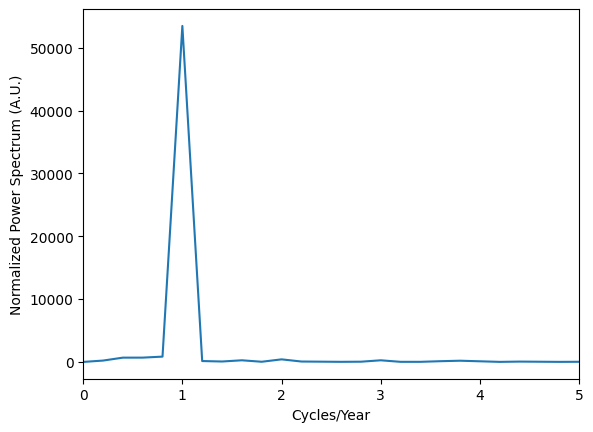

In [66]:
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was subtracted because 
#we want the evaluate the importance of the non-null frequency components

samp_freq=365 #365 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure();
plt.plot(f,fTS)
plt.xlim([0,5])
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")

Seasonality assessment by filtering

Text(0.5, 0, 'Time (Years)')

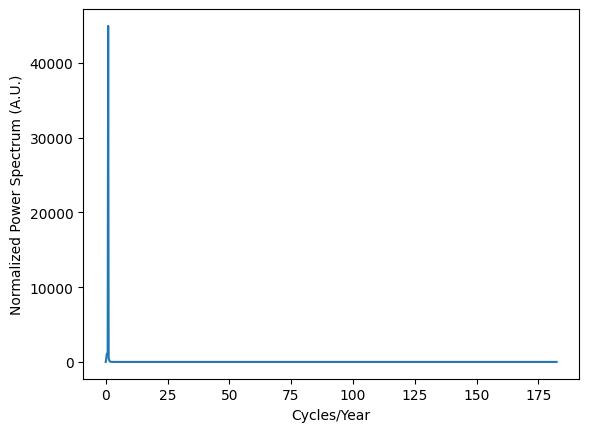

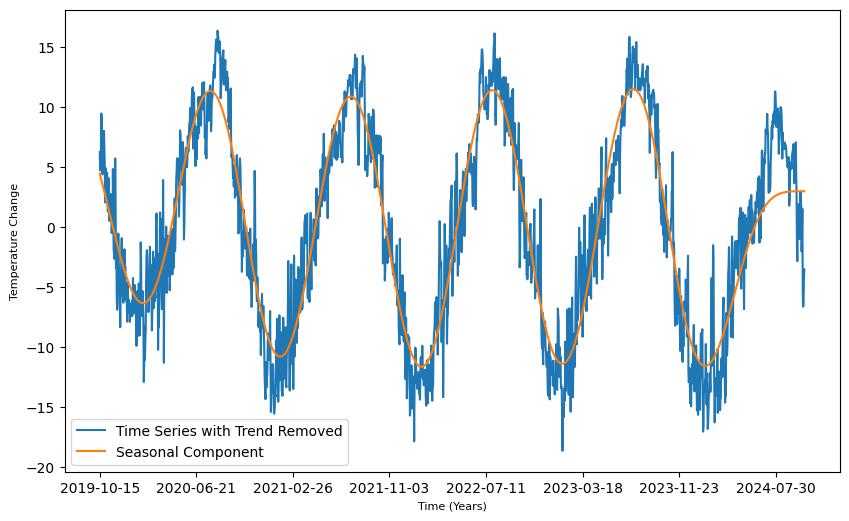

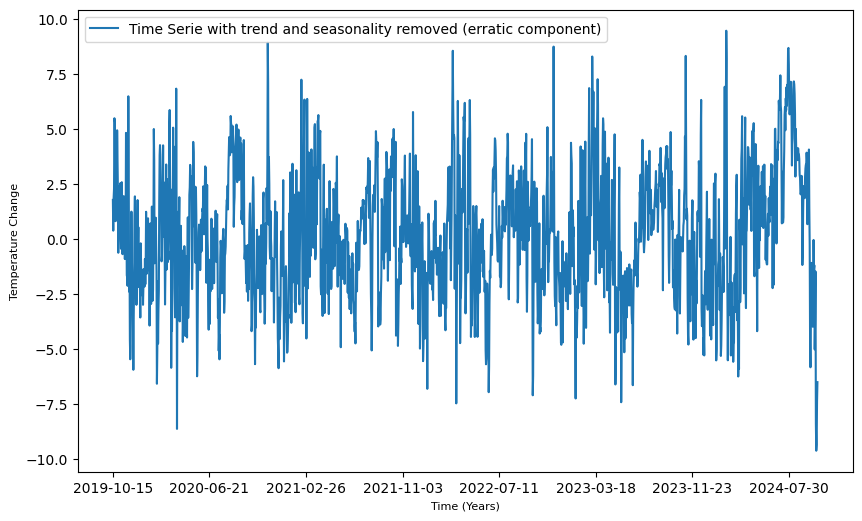

In [69]:
sos=scs.butter(N=5,fs=365,Wn=[1.4],btype='lowpass',output='sos')

Seasonal = scs.sosfiltfilt(sos,psNoTrend)


#Lets look at the filter effect
fTS=(np.abs(np.fft.rfft(Seasonal-np.mean(Seasonal)))**2/psNoTrend.size)# Mean was subtracted because 
#we want the evaluate the importance of the non-null frequency components

samp_freq=365 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure();
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")


#Plot Seasonal component as compared with the TS without trend
SeaTS=pd.Series(data=Seasonal,index=tempTS.index,name="Seasonal Component")
plt.figure(figsize=(10, 6))
ax=psNoTrend.plot(legend=True)
SeaTS.plot(legend=True)
ax.set_ylabel('Temperature Change', fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':8})

#Remove seasonal component by assuming the multiplicative model
psNoTrendNoSeas=psNoTrend - SeaTS
psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"

plt.figure(figsize=(10, 6))
ax=psNoTrendNoSeas.plot(legend=True)
ax.set_ylabel('Temperature Change', fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':8})


Seasonality assessment by epoch averaging

5


Text(0.5, 0, 'Time (Years)')

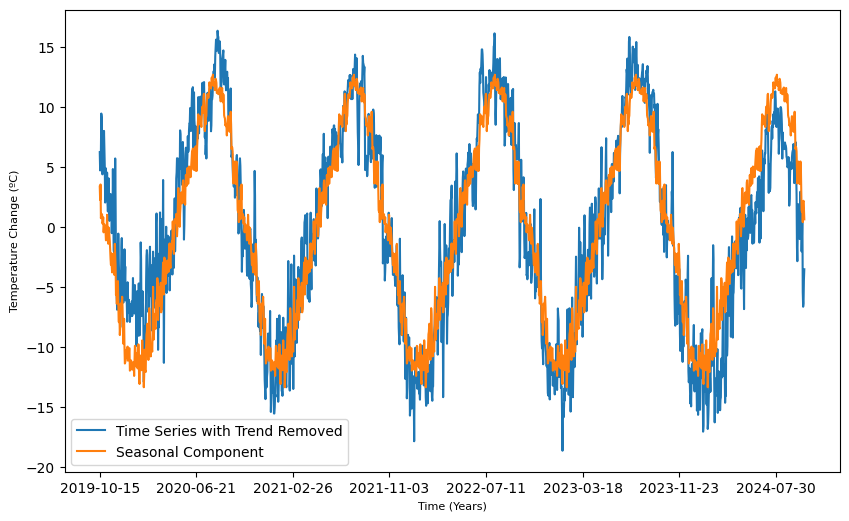

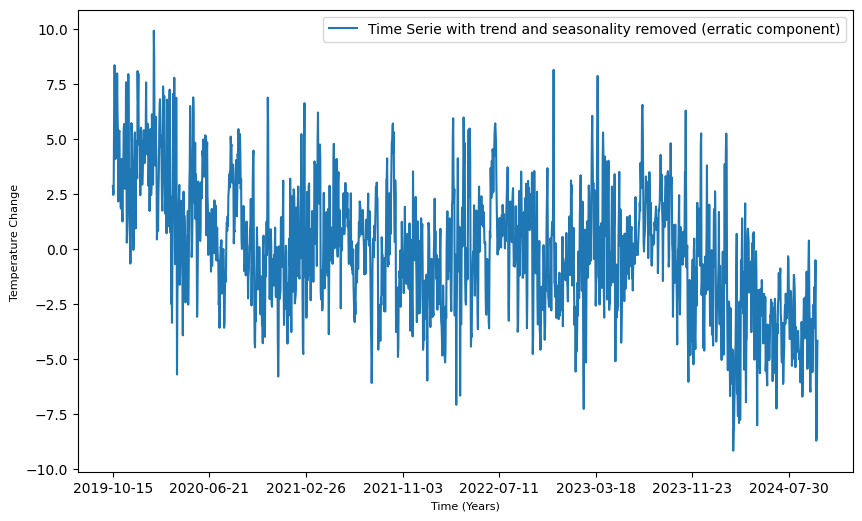

In [63]:
S=365


N=psNoTrend.size
C=int(np.floor(N/S))
print(C)

psNoTrend2=psNoTrend[0:C*S]

reshTS=np.array(psNoTrend2).reshape((C,S))#Reshape 1 column per month

ac=np.tile(np.mean(reshTS,axis=0),(C,))
SeaTS=pd.Series(data=ac,index=psNoTrend2.index,name="Seasonal Component")

plt.figure(figsize=(10, 6))
ax=psNoTrend2.plot(legend=True)
SeaTS.plot(legend=True)
ax.set_ylabel('Temperature Change (ºC)', fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)', fontdict={'fontsize':8})


#Remove seasonal component by assuming the additive model
psNoTrendNoSeas=psNoTrend - SeaTS
psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"

plt.figure(figsize=(10, 6))
ax=psNoTrendNoSeas.plot(legend=True)
ax.set_ylabel('Temperature Change ',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})

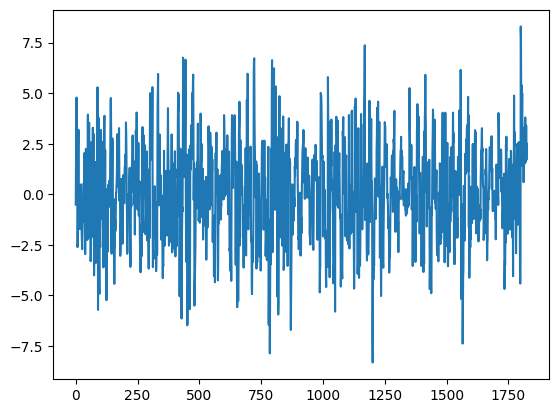

In [64]:
arr = np.array(df['temperature_mean'])
n_years = 5
slice_size = 365 * n_years
arr = arr[:slice_size]

for i in range(0, arr.shape[0]- 30, 30):
    arr[i:i+30] -= arr[i:i+30].mean()

plt.figure()
plt.plot(arr)
plt.show()

Text(0.5, 23.52222222222222, 'Time ')

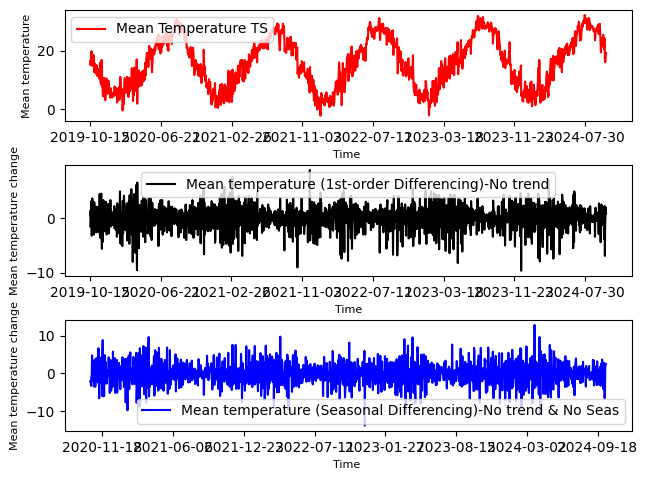

In [65]:
fig, axs=plt.subplots(3)
fig.tight_layout()
tempTS.plot(ax=axs[0],legend=True,color='r')
axs[0].set_ylabel('Mean temperature',fontdict={'fontsize':8})
axs[0].set_xlabel('Time ',fontdict={'fontsize':8})

d1psTS=tempTS.diff()
d1psTS.name="Mean temperature (1st-order Differencing)-No trend"
d1psTS.plot(ax=axs[1],legend=True,color='k')
axs[1].set_ylabel('Mean temperature change',fontdict={'fontsize':8})
axs[1].set_xlabel('Time',fontdict={'fontsize':8})

d1psTS=d1psTS.diff(365)
d1psTS.name="Mean temperature (Seasonal Differencing)-No trend & No Seas"
d1psTS.plot(ax=axs[2],legend=True,color='b')
axs[2].set_ylabel('Mean temperature change',fontdict={'fontsize':8})
axs[2].set_xlabel('Time ',fontdict={'fontsize':8})

### Exponential Smoothing

d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


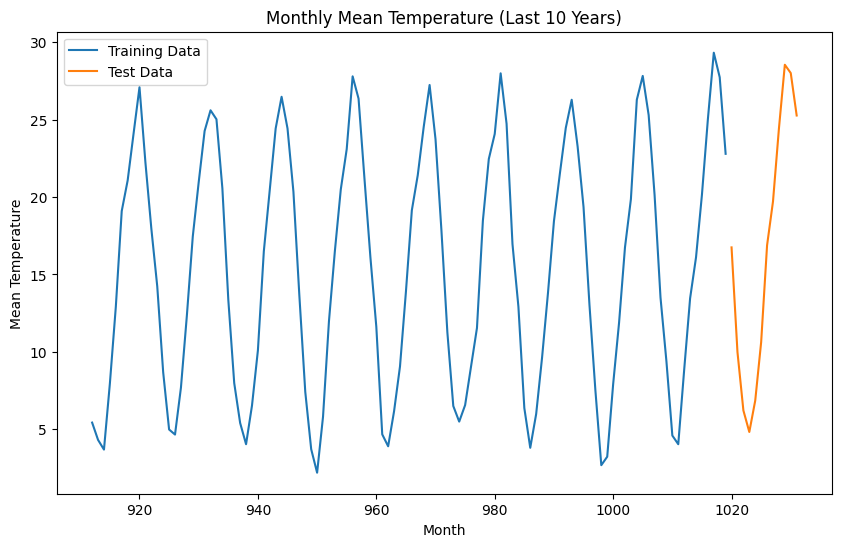

TES - Mean Squared Error (MSE): 4.360779644953165
TES - Root Mean Squared Error (RMSE): 2.0882479845442603
TES - Mean Absolute Error (MAE): 1.5929421419544016
TES - Mean Absolute Percentage Error (MAPE): 13.01747633690417%


In [ ]:
n = len(y)
groups = pd.Series(y).iloc[:n - n % 30].groupby(np.arange(n - n % 30) // 30)
original_ts = groups.mean()
original_ts = original_ts[-12*10:]

# Split data: training set (all data except last year) and test set (last year)
train,  test = original_ts[:-12],original_ts[-12:]

# Extract the time index for train and test
train_index = original_ts.index[:-12]  # Indices for training data
test_index = original_ts.index[-12:]  # Indices for test data
forecast_index = test_index           # Forecast will align with the test index




# Fit TES model (additive trend and seasonality)
tes_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
tes_forecast = tes_model.forecast(steps=12)

tes_forecast = pd.Series(tes_forecast.values, index=test.index)

# Plot TES results
plt.figure(figsize=(10, 6))
plt.plot(train_index, train, label='Training Data')
plt.plot(test_index, test, label='Test Data')
plt.plot(forecast_index, tes_forecast, label='TES Forecast', color='green')
plt.legend(loc='best')
plt.title("Monthly Mean Temperature Forecast Using TES (Last 10 Years)")
plt.xlabel("Month")
plt.ylabel("Mean Temperature")
plt.show()




# Evaluation for TES
tes_mse = mean_squared_error(test, tes_forecast)
tes_rmse = np.sqrt(tes_mse)
tes_mae = mean_absolute_error(test, tes_forecast)
tes_mape = np.mean(
    np.abs((test - tes_forecast) / test.replace(0, np.nan))
) * 100


print(f"TES - Mean Squared Error (MSE): {tes_mse}")
print(f"TES - Root Mean Squared Error (RMSE): {tes_rmse}")
print(f"TES - Mean Absolute Error (MAE): {tes_mae}")
print(f"TES - Mean Absolute Percentage Error (MAPE): {tes_mape}%")


d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


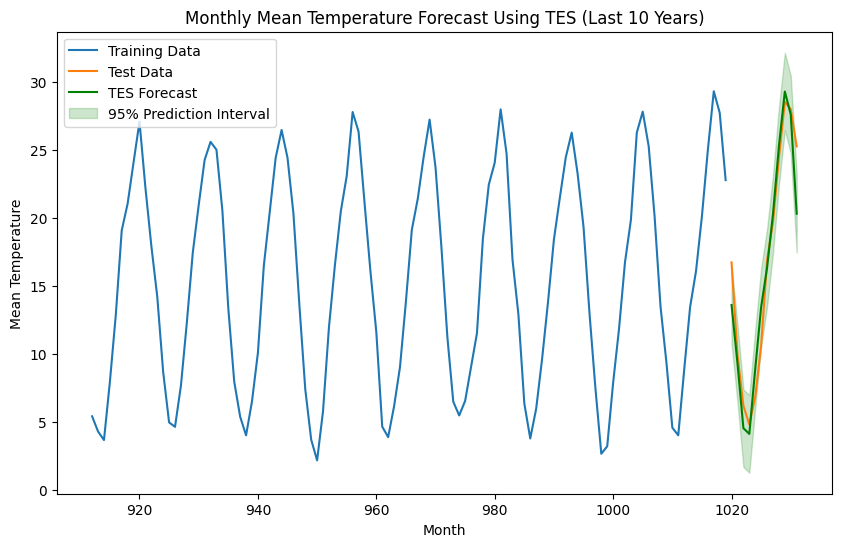

TES - Mean Squared Error (MSE): 4.360779644953165
TES - Root Mean Squared Error (RMSE): 2.0882479845442603
TES - Mean Absolute Error (MAE): 1.5929421419544016
TES - Mean Absolute Percentage Error (MAPE): 13.01747633690417%


In [14]:
# Fit TES model (additive trend and seasonality)
tes_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
tes_forecast = tes_model.forecast(steps=12)

# Estimate prediction intervals (95% confidence interval)
# Standard deviation of residuals
residuals = train - tes_model.fittedvalues
std_error = residuals.std()

# Calculate prediction intervals
z_score = 1.96  # For 95% confidence
forecast_upper = tes_forecast + z_score * std_error
forecast_lower = tes_forecast - z_score * std_error

# Convert forecast and intervals to a pandas Series with test index
tes_forecast = pd.Series(tes_forecast.values, index=test.index)
forecast_upper = pd.Series(forecast_upper.values, index=test.index)
forecast_lower = pd.Series(forecast_lower.values, index=test.index)

# Plot TES results with prediction intervals
plt.figure(figsize=(10, 6))
plt.plot(train_index, train, label='Training Data')
plt.plot(test_index, test, label='Test Data')
plt.plot(forecast_index, tes_forecast, label='TES Forecast', color='green')
plt.fill_between(
    forecast_index,
    forecast_lower,
    forecast_upper,
    color='green',
    alpha=0.2,
    label='95% Prediction Interval'
)
#forecast_upper.plot(linestyle="--",legend=True)
#forecast_lower.plot(linestyle="--",legend=True)
plt.legend(loc='best')
plt.title("Monthly Mean Temperature Forecast Using TES (Last 10 Years)")
plt.xlabel("Month")
plt.ylabel("Mean Temperature")
plt.show()

# Evaluation for TES
tes_mse = mean_squared_error(test, tes_forecast)
tes_rmse = np.sqrt(tes_mse)
tes_mae = mean_absolute_error(test, tes_forecast)
tes_mape = np.mean(np.abs((test - tes_forecast) / test.replace(0, np.nan))) * 100

print(f"TES - Mean Squared Error (MSE): {tes_mse}")
print(f"TES - Root Mean Squared Error (RMSE): {tes_rmse}")
print(f"TES - Mean Absolute Error (MAE): {tes_mae}")
print(f"TES - Mean Absolute Percentage Error (MAPE): {tes_mape}%")

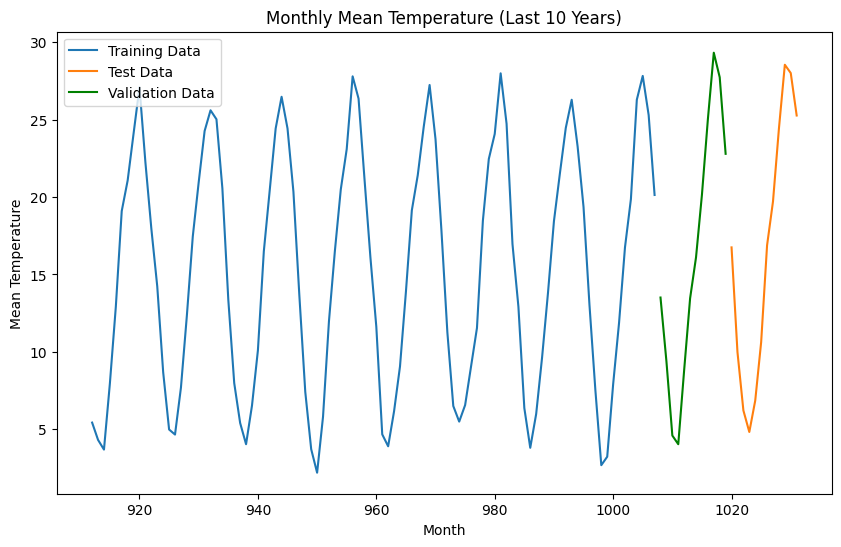

In [4]:
n = len(y)
groups = pd.Series(y).iloc[:n - n % 30].groupby(np.arange(n - n % 30) // 30)
original_ts2 = groups.mean()
original_ts2 = original_ts2[-12*10:]

# Split data: training set (all data except last year) and test set (last year)
train, val, test = original_ts2[:-24], original_ts2[-24:-12], original_ts2[-12:]

# Extract the time index for train and test
train_index = original_ts2.index[:-24]  # Indices for training data
test_index = original_ts2.index[-12:]  # Indices for test data
val_index = original_ts2.index[-24:-12]
forecast_index = test_index           # Forecast will align with the test index





# Plot TES results
plt.figure(figsize=(10, 6))
plt.plot(train_index, train, label='Training Data')
plt.plot(test_index, test, label='Test Data')
plt.plot(val_index, val, label='Validation Data', color='green')
plt.legend(loc='best')
plt.title("Monthly Mean Temperature (Last 10 Years)")
plt.xlabel("Month")
plt.ylabel("Mean Temperature")
plt.show()





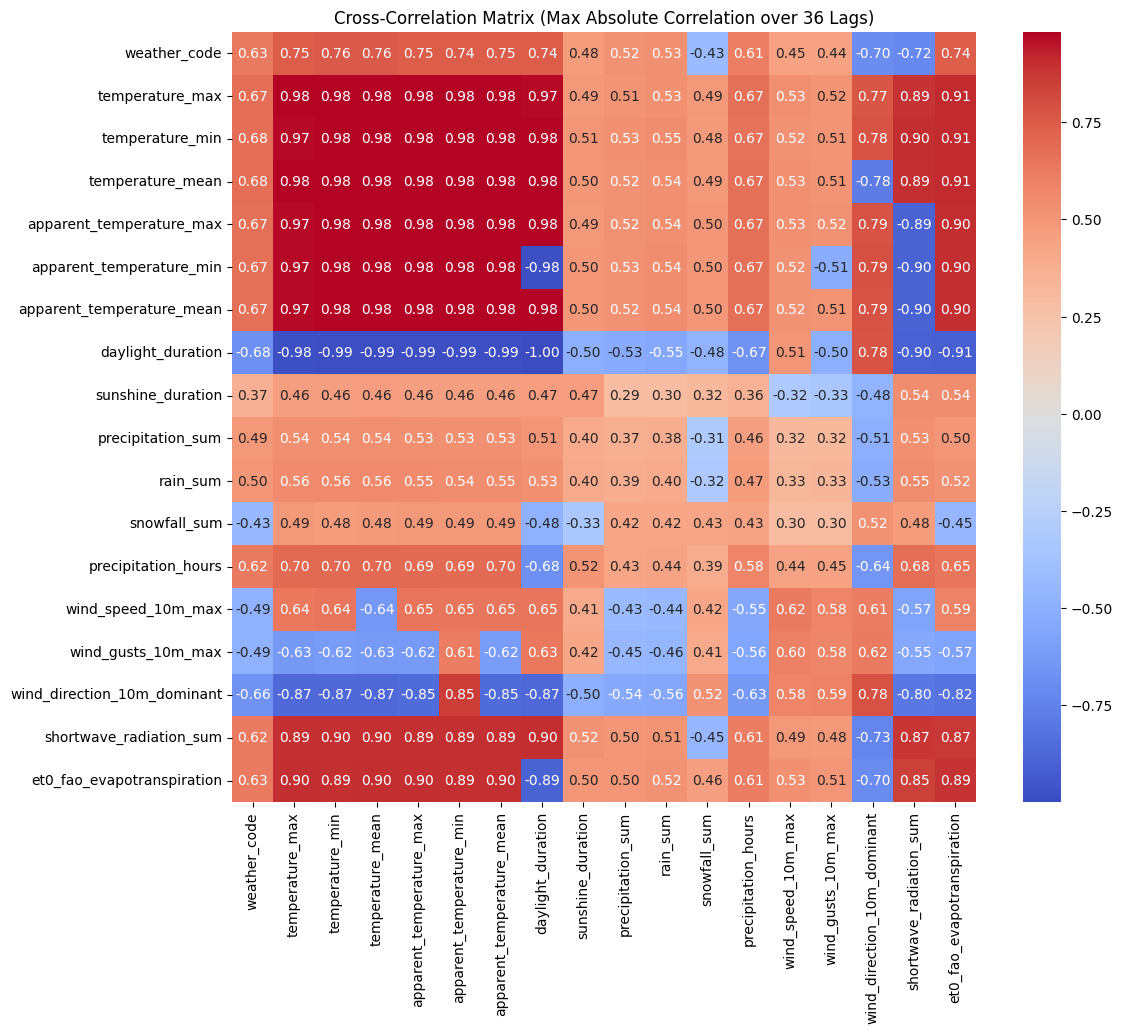

In [14]:

data = df

# Select numeric columns for analysis
data_numeric = data.select_dtypes(include=[np.number])

# Step 1: Group data by 30-day intervals and compute monthly averages
n = len(data_numeric)
groups = data_numeric.iloc[:n - n % 30].groupby(np.arange(n - n % 30) // 30)
data_numeric_t = groups.mean()

# Step 2: Retain only the last 10 years (120 months)
data_numeric_t = data_numeric_t[-12 * 10:]

# Define the maximum lag
max_lag = 36

# Function to calculate cross-correlation
def compute_cross_correlation_matrix(data, max_lag):
    variables = data.columns
    cross_corr_matrix = pd.DataFrame(index=variables, columns=variables)
    
    for var1 in variables:
        for var2 in variables:
            # Compute max absolute correlation across lags
            correlations = [np.corrcoef(data[var1][lag:], data[var2][:-lag])[0, 1]
                            for lag in range(1, max_lag + 1)]
            cross_corr_matrix.loc[var1, var2] = max(correlations, key=abs)
    
    return cross_corr_matrix.astype(float)

# Compute the cross-correlation matrix
cross_corr_matrix = compute_cross_correlation_matrix(data_numeric_t, max_lag)

# Visualize using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title(f"Cross-Correlation Matrix (Max Absolute Correlation over {max_lag} Lags)")
plt.show()


In [15]:
# Aggregate into monthly averages (if not already aggregated)
n = len(data_numeric)
groups = data_numeric.iloc[:n - n % 30].groupby(np.arange(n - n % 30) // 30)
data_numeric_t = groups.mean()[-12 * 10:]  # Keep last 10 years

# Normalize the data (z-score normalization)
data_normalized = (data_numeric_t - data_numeric_t.mean()) / data_numeric_t.std()

# Differentiation (to make data stationary)
data_differentiated = data_normalized.diff().diff(12).dropna()


# Generate cross-correlation plots for all variable pairs
variables = data_differentiated.columns
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:  # Avoid duplicate plots and self-correlation
            # Compute cross-correlation
            cross_corr = ccf(data_differentiated[var1], data_differentiated[var2], adjusted=False)

            # Create plot
            plt.figure(figsize=(6, 4))
            plt.stem(range(len(cross_corr)), cross_corr, basefmt=" ")  # Removed 'use_line_collection'
            plt.axhline(y=0, color='black', linewidth=0.8)
            plt.axhline(y=1.96 / np.sqrt(len(data_differentiated)), color='red', linestyle='--', linewidth=0.8)
            plt.axhline(y=-1.96 / np.sqrt(len(data_differentiated)), color='red', linestyle='--', linewidth=0.8)
            plt.title(f'Cross-Correlation: {var1} vs {var2}')
            plt.xlabel('Lag')
            plt.ylabel('Cross-Correlation')
            plt.tight_layout()

            # Save or show
            plot_filename = f"cross_corr_{var1}_vs_{var2}_diff.png"
            plt.savefig(plot_filename)
            plt.close()  # Close the figure to avoid overlap

            print(f"Saved plot: {plot_filename}")

Saved plot: cross_corr_weather_code_vs_temperature_max_diff.png
Saved plot: cross_corr_weather_code_vs_temperature_min_diff.png
Saved plot: cross_corr_weather_code_vs_temperature_mean_diff.png
Saved plot: cross_corr_weather_code_vs_apparent_temperature_max_diff.png
Saved plot: cross_corr_weather_code_vs_apparent_temperature_min_diff.png
Saved plot: cross_corr_weather_code_vs_apparent_temperature_mean_diff.png
Saved plot: cross_corr_weather_code_vs_daylight_duration_diff.png
Saved plot: cross_corr_weather_code_vs_sunshine_duration_diff.png
Saved plot: cross_corr_weather_code_vs_precipitation_sum_diff.png
Saved plot: cross_corr_weather_code_vs_rain_sum_diff.png
Saved plot: cross_corr_weather_code_vs_snowfall_sum_diff.png
Saved plot: cross_corr_weather_code_vs_precipitation_hours_diff.png
Saved plot: cross_corr_weather_code_vs_wind_speed_10m_max_diff.png
Saved plot: cross_corr_weather_code_vs_wind_gusts_10m_max_diff.png
Saved plot: cross_corr_weather_code_vs_wind_direction_10m_dominant_di

: 

Only correlation between mean temperature and others

In [19]:
# Aggregate into monthly averages (if not already aggregated)
n = len(data_numeric)
groups = data_numeric.iloc[:n - n % 30].groupby(np.arange(n - n % 30) // 30)
data_numeric_t = groups.mean()[-12 * 10:]  # Keep last 10 years

# Normalize the data (z-score normalization)
data_normalized = (data_numeric_t - data_numeric_t.mean()) / data_numeric_t.std()

# Differentiation (to make data stationary)
data_differentiated = data_normalized.diff().diff(12).dropna()

# Reference variable: mean temperature
target_var = 'temperature_mean'

# Generate cross-correlation plots with mean temperature
for var in data_differentiated.columns:
    
    # Compute cross-correlation
    cross_corr = ccf(data_differentiated[target_var], data_differentiated[var], adjusted=False)
    # Create plot
    plt.figure(figsize=(6, 4))
    plt.stem(range(len(cross_corr)), cross_corr, basefmt=" ")  # Removed 'use_line_collection'
    plt.axhline(y=0, color='black', linewidth=0.8)
    plt.axhline(y=1.96 / np.sqrt(len(data_differentiated)), color='red', linestyle='--', linewidth=0.8)
    plt.axhline(y=-1.96 / np.sqrt(len(data_differentiated)), color='red', linestyle='--', linewidth=0.8)
    plt.title(f'Cross-Correlation: {target_var} vs {var}')
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.tight_layout()
    
    # Show the plot
    #plt.show()

    #save
    plot_filename = f"cross_corr_{target_var}_vs_{var}_diff.png"
    plt.savefig(plot_filename)
    plt.close()  # Close the figure to avoid overlap
    print(f"Saved plot: {plot_filename}")




Saved plot: cross_corr_temperature_mean_vs_weather_code_diff.png
Saved plot: cross_corr_temperature_mean_vs_temperature_max_diff.png
Saved plot: cross_corr_temperature_mean_vs_temperature_min_diff.png
Saved plot: cross_corr_temperature_mean_vs_temperature_mean_diff.png
Saved plot: cross_corr_temperature_mean_vs_apparent_temperature_max_diff.png
Saved plot: cross_corr_temperature_mean_vs_apparent_temperature_min_diff.png
Saved plot: cross_corr_temperature_mean_vs_apparent_temperature_mean_diff.png
Saved plot: cross_corr_temperature_mean_vs_daylight_duration_diff.png
Saved plot: cross_corr_temperature_mean_vs_sunshine_duration_diff.png
Saved plot: cross_corr_temperature_mean_vs_precipitation_sum_diff.png
Saved plot: cross_corr_temperature_mean_vs_rain_sum_diff.png
Saved plot: cross_corr_temperature_mean_vs_snowfall_sum_diff.png
Saved plot: cross_corr_temperature_mean_vs_precipitation_hours_diff.png
Saved plot: cross_corr_temperature_mean_vs_wind_speed_10m_max_diff.png
Saved plot: cross_c

VAR AND VARMA

In [4]:
def calculate_metrics(true, pred):
        mse = mean_squared_error(true, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(true, pred)
        mape = np.mean(np.abs((true - pred) / true)) * 100
        return mse, rmse, mae, mape

In [21]:
columns_of_interest = ['temperature_mean', 'temperature_max', 'temperature_min', 'apparent_temperature_mean']  
data = df[columns_of_interest]

# Check for missing values and handle them (e.g., fill or drop)
data = data.dropna()

# Aggregate into monthly averages (if not already aggregated)
n = len(data)
groups = data.iloc[:n - n % 30].groupby(np.arange(n - n % 30) // 30)
data = groups.mean()  # Monthly aggregation

# Keep only the last 10 years
data = data[-12 * 10:]

# Normalize the data (optional but recommended)
#data_normalized = (data - data.mean()) / data.std()

# Differentiation (to make data stationary)
#data_differentiated = data_normalized.diff().diff(12).dropna()
data_differentiated = data

# Split the data into train and test
# Split data: training set (all data except last year) and test set (last year)
train,  test = data_differentiated[:-12],data_differentiated[-12:]

# Extract the time index for train and test
train_index = data_differentiated.index[:-12]  # Indices for training data
test_index = data_differentiated.index[-12:]  # Indices for test data
forecast_index = test_index           # Forecast will align with the test index


d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


VAR Summary:
   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Dec, 2024
Time:                     21:04:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -18.2839
Nobs:                     176.000    HQIC:                  -20.8966
Log likelihood:           1240.85    FPE:                1.59403e-10
AIC:                     -22.6794    Det(Omega_mle):     4.84789e-11
--------------------------------------------------------------------
Results for equation temperature_mean
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                -0.002497         0.012810           -0.195           0.845
L1.temperature_mean                  -1.822295         1.361971     

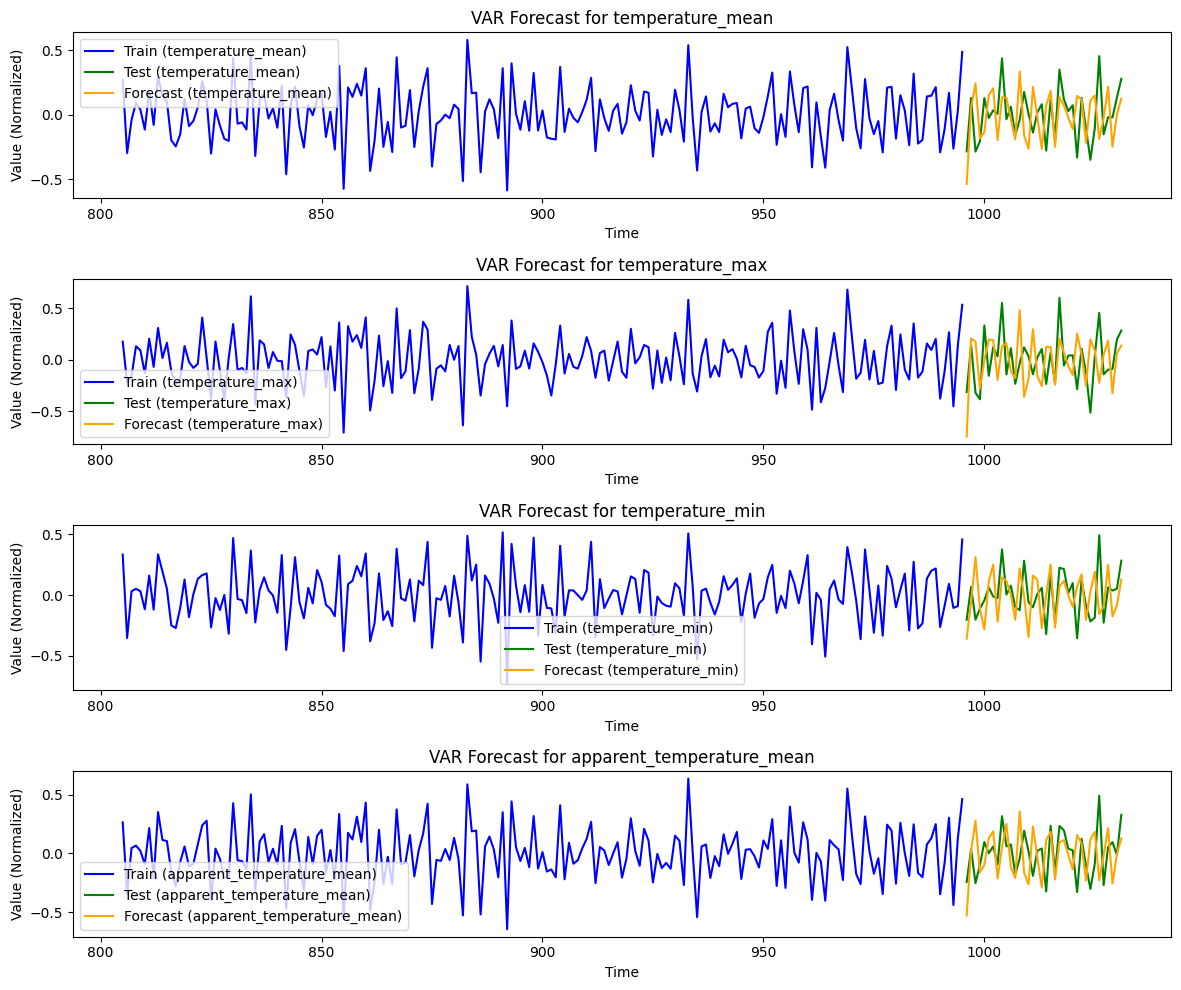

temperature_mean             0
temperature_max              0
temperature_min              0
apparent_temperature_mean    0
dtype: int64


d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


VARMA Summary:
                                                               Statespace Model Results                                                             
Dep. Variable:     ['temperature_mean', 'temperature_max', 'temperature_min', 'apparent_temperature_mean']   No. Observations:                  191
Model:                                                                                              VAR(1)   Log Likelihood                1003.413
                                                                                               + intercept   AIC                          -1946.825
Date:                                                                                     Mon, 02 Dec 2024   BIC                          -1849.257
Time:                                                                                             21:04:26   HQIC                         -1907.306
Sample:                                                                                         

d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


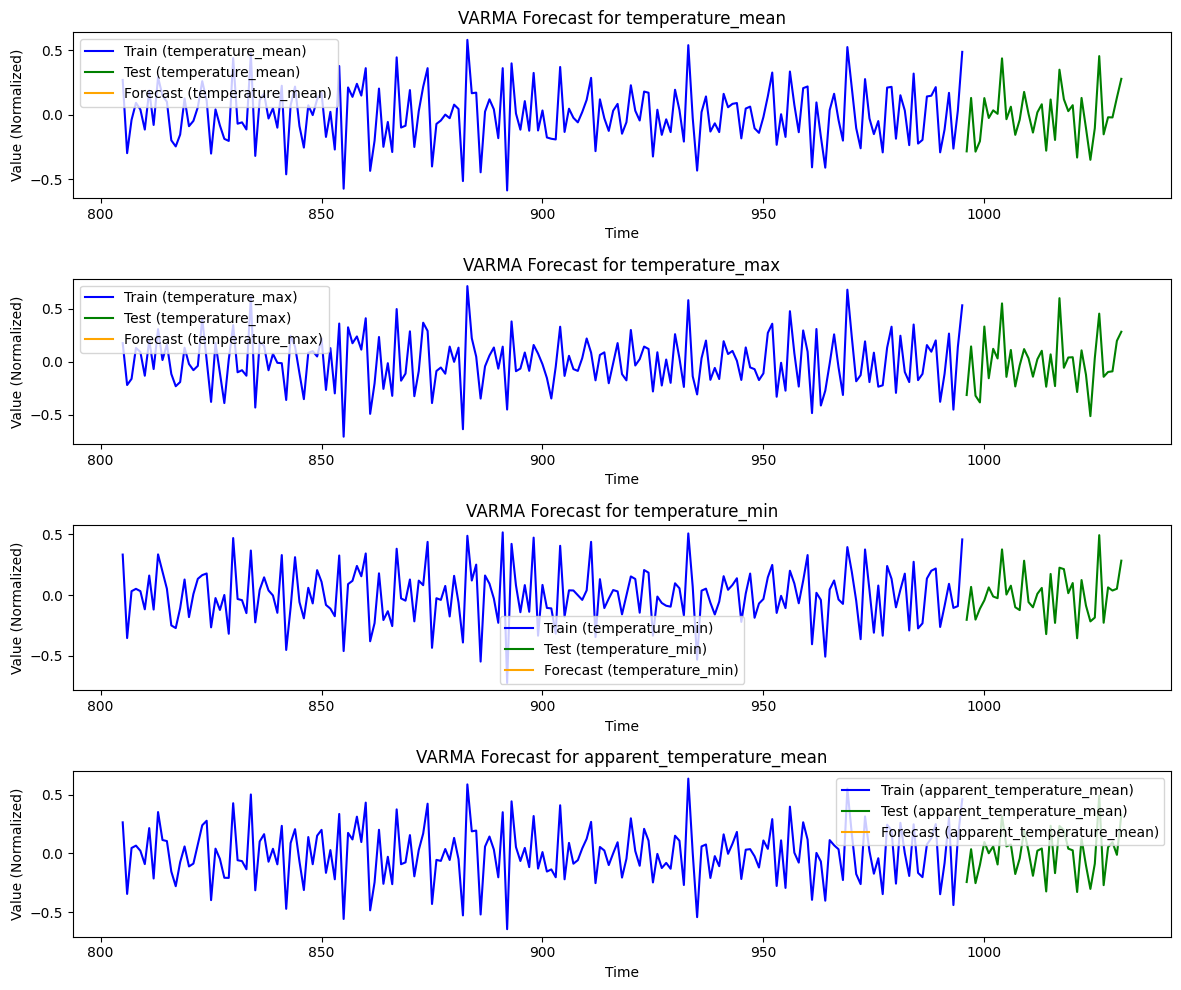

In [ ]:


# Train the VAR model
var_model = VAR(train)
var_fit = var_model.fit(maxlags=15, ic='aic')  # Automatically chooses the optimal lags
print("VAR Summary:\n", var_fit.summary())

# Forecast using VAR
forecast_steps = len(test)
forecast = var_fit.forecast(y=train.values[-var_fit.k_ar:], steps=forecast_steps)

# Prepare the forecast DataFrame
forecast_index = test.index  # Use the test data's index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)

# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each column and plot in a different subplot
for i, col in enumerate(data.columns):
    ax = axes[i]
    
    # Plot train data
    ax.plot(train[col], label=f"Train ({col})", color='blue')
    
    # Plot test data
    ax.plot(test[col], label=f"Test ({col})", color='green')
    
    # Plot forecast
    ax.plot(forecast_df[col], label=f"Forecast ({col})", color='orange')
    print(calculate_metrics(test[col],forecast_df[col]))
    # Add title, labels, and legend
    ax.set_title(f"VAR Forecast for {col}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value (Normalized)")
    ax.legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()



print(train.isna().sum())  # Missing values
#print(train.isinf(train).sum())  # Infinite values



(np.float64(54.77203658659738), np.float64(7.400813238191961), np.float64(7.252861505802095), np.float64(65.47427134878208))
(np.float64(55.04523479935559), np.float64(7.4192475898406025), np.float64(7.227924601891915), np.float64(41.42506958505318))
(np.float64(58.06079232675095), np.float64(7.619763272356363), np.float64(7.495396258067651), np.float64(260.98206301931464))
(np.float64(101.67470715949061), np.float64(10.083387682693283), np.float64(9.92693940118874), np.float64(1177.682956041799))


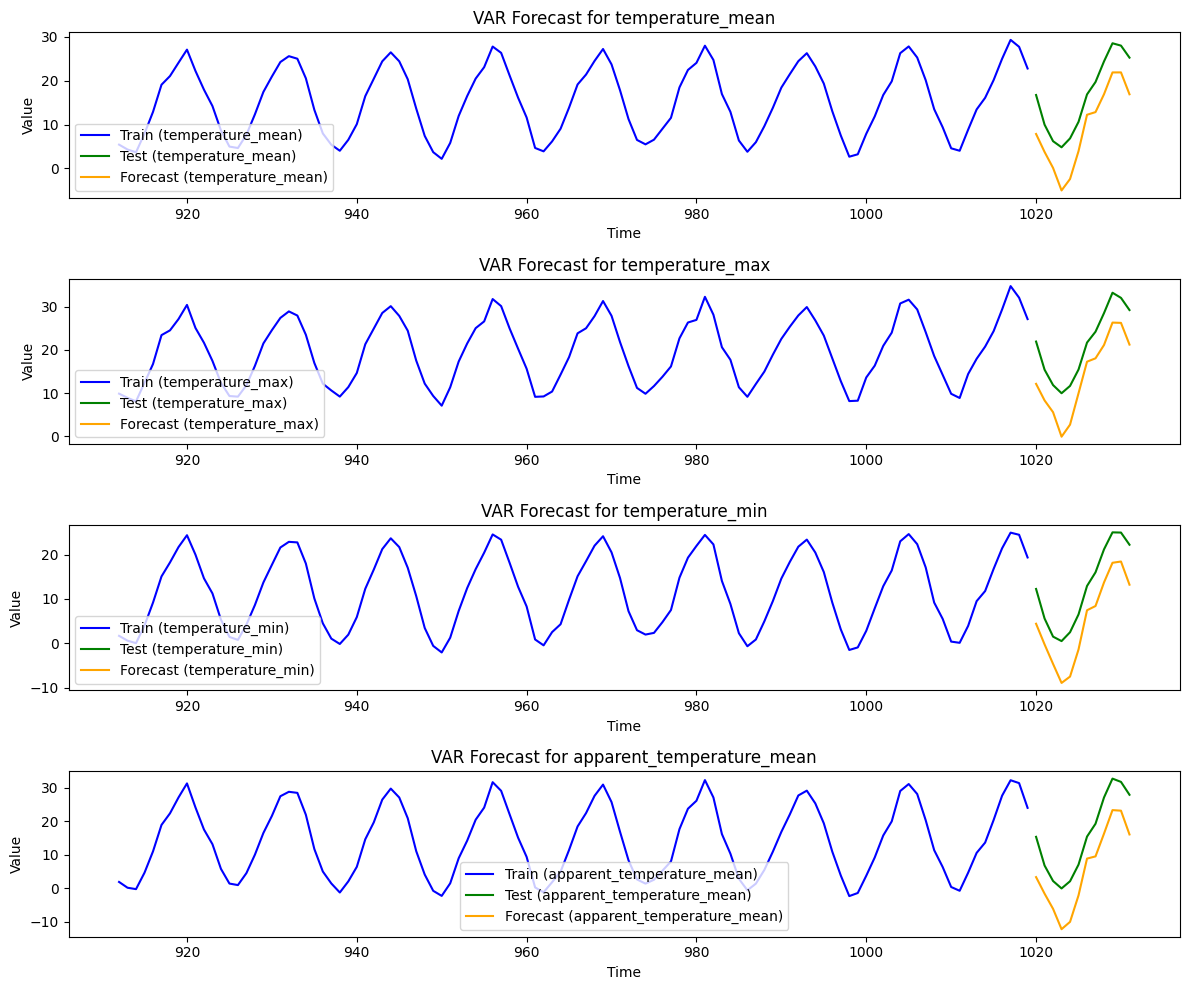

In [38]:
# Reverse Differentiation (Cumulative Sum)
forecast_cumsum = forecast_df.cumsum(axis=0)

# Reverse Normalization
forecast_original = forecast_cumsum * data.std().values + data.mean().values

# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Split data: training set (all data except last year) and test set (last year)
trainn,  testt = data[:-12],data[-12:]

# Extract the time index for train and test
train_index = data.index[:-12]  # Indices for training data
test_index = data.index[-12:]  # Indices for test data
forecast_index = test_index           # Forecast will align with the test index


# Loop through each column and plot in a different subplot
for i, col in enumerate(data.columns):
    ax = axes[i]
    
    # Plot train data
    ax.plot(train_index, trainn[col], label=f"Train ({col})", color='blue')
    
    # Plot test data
    ax.plot(test_index, testt[col], label=f"Test ({col})", color='green')
    
    # Plot forecast (converted back to original scale)
    ax.plot(forecast_index, forecast_original[col], label=f"Forecast ({col})", color='orange')
    
    # Add title, labels, and legend
    ax.set_title(f"VAR Forecast for {col}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend()
    print(calculate_metrics(testt[col],forecast_original[col]))

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()



temperature_mean             0
temperature_max              0
temperature_min              0
apparent_temperature_mean    0
dtype: int64
       temperature_mean  temperature_max  temperature_min  \
count        191.000000       191.000000       191.000000   
mean           0.002079         0.002266         0.001748   
std            0.221383         0.246748         0.226299   
min           -0.588021        -0.708736        -0.722688   
25%           -0.144802        -0.171326        -0.135405   
50%            0.019727        -0.009727         0.008339   
75%            0.148999         0.158725         0.136596   
max            0.579626         0.716252         0.515015   

       apparent_temperature_mean  
count                 191.000000  
mean                    0.002051  
std                     0.235569  
min                    -0.646654  
25%                    -0.145288  
50%                     0.019558  
75%                     0.147771  
max                     0.638893 

D:\WINDOWS\Local\Temp\ipykernel_29660\2521503823.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='ffill').fillna(method='bfill')
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

VARMA Summary:
                                                               Statespace Model Results                                                             
Dep. Variable:     ['temperature_mean', 'temperature_max', 'temperature_min', 'apparent_temperature_mean']   No. Observations:                  191
Model:                                                                                          VARMA(1,1)   Log Likelihood                1029.185
                                                                                               + intercept   AIC                          -1966.370
Date:                                                                                     Mon, 02 Dec 2024   BIC                          -1816.765
Time:                                                                                             21:46:27   HQIC                         -1905.773
Sample:                                                                                         

d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\programas\envs\astp_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


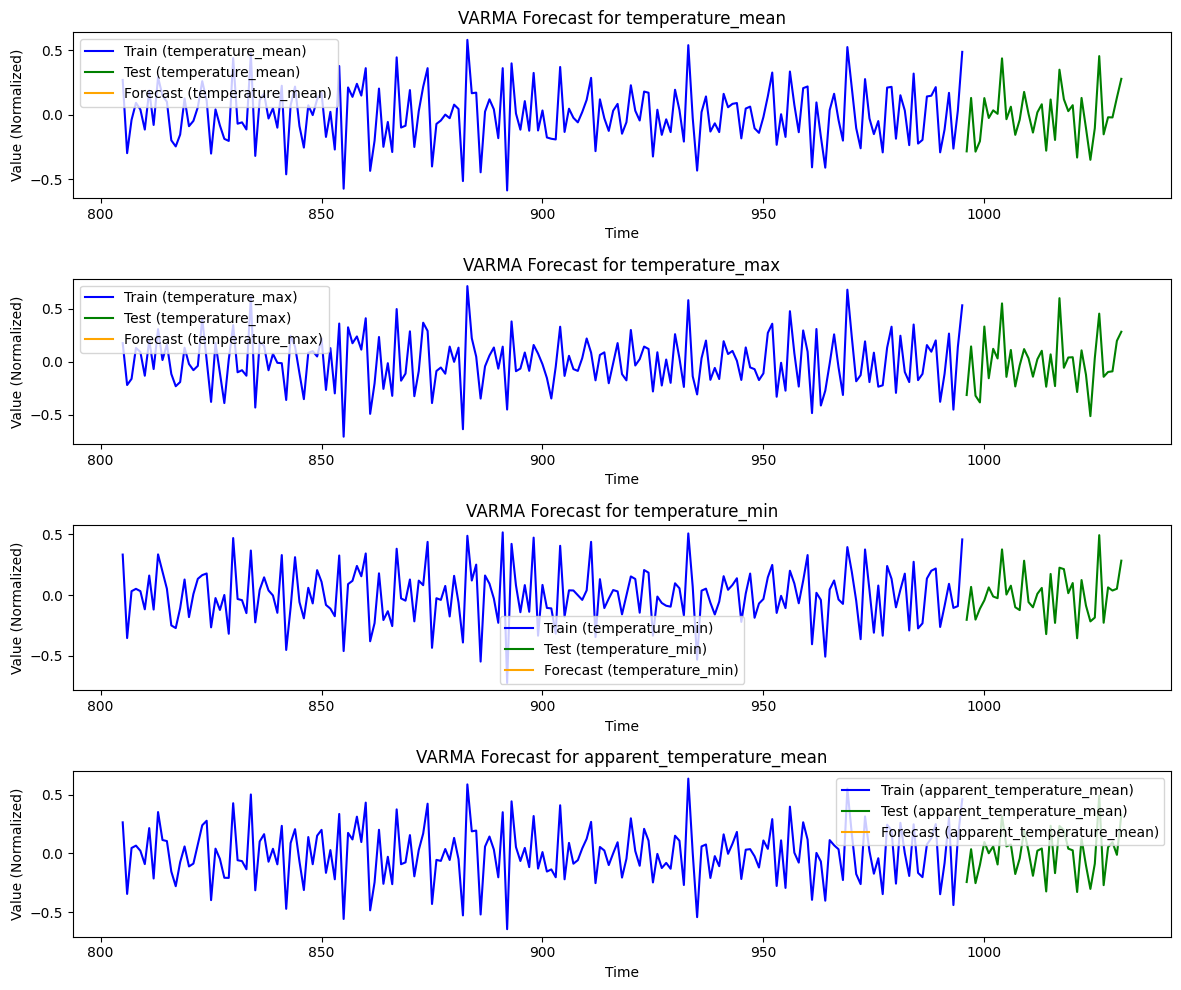

In [ ]:

train = train.fillna(method='ffill').fillna(method='bfill')

# Train VARMA Model
varma_model = VARMAX(train, order=(1, 1), exog=None)
varma_fit = varma_model.fit(disp=False)

print("VARMA Summary:\n", varma_fit.summary())
print(varma_fit.params)

# Forecast with VARMA
forecast_steps = len(test)
forecast_varma = varma_fit.forecast(steps=forecast_steps)

# Prepare forecast DataFrame for VARMA
forecast_varma_df = pd.DataFrame(forecast_varma, index=forecast_index, columns=data.columns)
print(forecast_varma_df)
# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each column and plot in a different subplot
for i, col in enumerate(data.columns):
    ax = axes[i]
    
    # Plot train data
    ax.plot(train[col], label=f"Train ({col})", color='blue')
    
    # Plot test data
    ax.plot(test[col], label=f"Test ({col})", color='green')
    
    # Plot forecast
    ax.plot(forecast_varma_df[col], label=f"Forecast ({col})", color='orange')
    
    # Add title, labels, and legend
    ax.set_title(f"VARMA Forecast for {col}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value (Normalized)")
    ax.legend()

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()




LLMS

In [33]:
def ollama(data):
    prompt = f"Based on values about 10 years of monthly mean temperatures, forecast the next 12 months and give the values in a array.\nValues:{data}\nonly output the array of forecast values."
    print(prompt)
    response = requests.post(
        'http://localhost:11434/api/generate',  
        json={
            "model": "llama3.2",  
            "prompt": prompt,
            "stream":False,
        }
    )
    if response.status_code == 200:
        
        response_text = response.text
        data = json.loads(response_text)
        return data["response"]
    else:
        print(f"Error: {response.status_code}")
        return None

In [34]:

print(train["temperature_mean"].to_list())

ollama(train["temperature_mean"].to_list())


[5.4366666666666665, 4.319999999999999, 3.6933333333333334, 7.97, 12.903333333333334, 19.09333333333333, 21.066666666666666, 24.09333333333333, 27.086666666666666, 22.23, 17.96333333333333, 14.226666666666667, 8.686666666666667, 4.989999999999999, 4.663333333333333, 7.693333333333333, 12.336666666666668, 17.45, 20.953333333333333, 24.263333333333332, 25.596666666666668, 25.016666666666666, 20.553333333333335, 13.370000000000001, 7.986666666666666, 5.41, 4.04, 6.533333333333333, 10.1, 16.493333333333332, 20.45, 24.423333333333336, 26.470000000000002, 24.426666666666666, 20.336666666666666, 13.646666666666667, 7.42, 3.7199999999999998, 2.2, 5.819999999999999, 11.976666666666667, 16.51, 20.490000000000002, 23.09, 27.790000000000003, 26.35, 21.176666666666666, 16.116666666666667, 11.623333333333333, 4.676666666666667, 3.9066666666666667, 6.173333333333333, 9.063333333333333, 13.876666666666667, 19.14, 21.41, 24.509999999999998, 27.23, 23.726666666666667, 17.833333333333332, 11.266666666666

'import numpy as np\nfrom scipy.stats import linregress\n\n# Given temperatures\ntemperatures = [5.4366666666666665, 4.319999999999999, 3.6933333333333334, 7.97, 12.903333333333334,\n                19.09333333333333, 21.066666666666666, 24.09333333333333, 27.086666666666666,\n                22.23, 17.96333333333333, 14.226666666666667, 8.686666666666667, 4.989999999999999,\n                4.663333333333333, 7.693333333333333, 12.336666666666668, 17.45, 20.953333333333333,\n                24.263333333333332, 25.596666666666668, 25.016666666666666, 20.553333333333335,\n                13.370000000000001, 7.986666666666666, 5.41, 4.04, 6.533333333333333, 10.1,\n                16.493333333333332, 20.45, 24.423333333333336, 26.470000000000002, 24.426666666666666,\n                20.336666666666666, 13.646666666666667, 7.42, 3.7199999999999998, 2.2,\n                5.819999999999999, 11.976666666666667, 16.51, 20.490000000000002, 23.09,\n                27.790000000000003, 26.35, 21.1